# EDA Madrid Central

We import the libraries that we are going to use later.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
%matplotlib inline
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

We import the air quality datasets for the years 2011 to 2021 from **[the city of Madrid's website](https://datos.madrid.es/sites/v/index.jsp?vgnextoid=aecb88a7e2b73410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD)**

In [2]:
datos_2011 = pd.read_csv(r".\datos - copia\datos11.csv", sep=";")
datos_2012 = pd.read_csv(r".\datos - copia\datos12.csv", sep=";")
datos_2013 = pd.read_csv(r".\datos - copia\datos13.csv", sep=";")
datos_2014 = pd.read_csv(r".\datos - copia\datos14.csv", sep=";")
datos_2015 = pd.read_csv(r".\datos - copia\datos15.csv", sep=";")
datos_2016 = pd.read_csv(r".\datos - copia\datos201612.csv", sep=";")
datos_2017 = pd.read_csv(r".\datos - copia\datos17.csv", sep=";")
datos_2018 = pd.read_csv(r".\datos - copia\datos201812.csv", sep=";")
datos_2019 = pd.read_csv(r".\datos - copia\datos201912.csv", sep=";")
datos_2020 = pd.read_csv(r".\datos - copia\datos202012.csv", sep=";")
datos_2021 = pd.read_csv(r".\datos - copia\datos202105.csv", sep=";")

### Data cleaning function
We are going to create some functions to help us cleaning the datasets.

In [3]:
def cleaning_valid(df):    
    """
    The columns with V validate the data of the columns D that correspond to them. For example, V01 will validate column D01 and V02 for D02, etc ... The value V corresponds to a valid data and N to an invalid data.
    The function iterates over these columns and when it encounters a data that is not valid, it assigns the value None in the column of the corresponding day.
    
    After the iteration, the validation columns will be eliminated.
    """
    
    # checking the verified data and replace the N with None
    for i in range(0, len(df.index)):
        for j in range(4, len(df.columns)):
            if df.iloc[i, j] == 'N':
                df.iloc[i, (j - 1)] = None
                
    # eliminating the validation columns (V01, V02..V31)
    for i in df.columns:
        if i.startswith("V"):
            df.drop(i, axis=1, inplace=True)
            
    return df

In [4]:
def columns_remove(df):
    """
    It removes the columns PROVINCIA, MUNICIPIO y PUNTO_MUESTRE which we are not interested in for our analysis.
    """
    df.drop(["PROVINCIA","MUNICIPIO","PUNTO_MUESTREO"], axis=1, inplace=True)
    
    return df

In [5]:
def adding_columns(df):
    """
    It creates new columns with data that we need to carry out our analysis:
        - a column with the date in datetime mode, to later set that column as index,
        - a column with the season of the year,
        - a column with the monthly pollution average.
        
    """
    # creating a Date column (from the columns with the year and month)
    df["Date"] = pd.to_datetime(df.ANO.astype(str) + '/' + df.MES.astype(str))
    
    # adding a column with the season of the year.
    season = []

    for i in df["MES"]:
        if 3<= i <=5 :
            season.append("Spring")
    
        elif 6<= i <= 8:
            season.append("Summer")

        elif 9<= i <= 11:
            season.append("Autumn")

        else:
            season.append("Winter")
        
    df["Season"] = season
    
    # adding a column with the monthy pollution mean. 
    Mean = []

    for i in range(0, len(df.index)):
    
        Mean.append(df.iloc[i, 4:35].mean())
    
    df["Mean per month(ug/m3)"] = Mean
    
    return df

In [6]:
def rename_col(df):
    """
    It changes the names of some columns and change the name of some variables (the type of pollutant, the name of the weather stations)
    
    """
    # replacing the magnitude type by the name of its pollutant

    df["MAGNITUD"].replace({8:"NO2"}, inplace=True)
    
    # replacing the station's number by their names
    df["ESTACION"].replace({4:"Plz de España", 35:"Plz del Carmen"}, inplace=True)
    
    # renaming the columns
    df.rename(columns={"ESTACION":"Station", "MAGNITUD":"Pollutant", "ANO": "Year", "MES":"Month"}, inplace=True)
    
    return df

In [7]:
def col_dia_remove(df):
    """
    It eliminates the columns with the days. Since we have the monthly averages, we are not going to use them anymore.
    """
    
    df.drop(columns=["D01", "D02", "D03","D04", "D05", "D06", "D07", "D08", "D09", "D10", "D11", "D12", "D13", "D14", "D15", "D16", "D17",
                         "D18", "D19", "D20", "D21", "D22", "D23", "D24", "D25", "D26", "D27", "D28", "D29", "D30", "D31"], inplace=True)
    
    return df

In [8]:
def slicing_estacion_magnitud(df):
    
    """
    It does a slicing to stay with the type of pollutant and the stations that interest us.
    """
    #slicing to filter the pollutant NO2
    df = df[df['Pollutant'] == "NO2"]
    
    #slicing to filter the 2 stations located within Madrid Central
    df = df[(df["Station"] == "Plz de España") | (df["Station"] == "Plz del Carmen") ]
    
    return df

In [9]:
def cleaning_data(df):
    """
    It will apply the 6 data cleaning functions which were previously created.
    """
    
    df = cleaning_valid(df)
    df = columns_remove(df)
    df = adding_columns(df)
    df = rename_col(df)
    df = col_dia_remove(df)
    df = slicing_estacion_magnitud(df)
    
    return df
    

### CLEANING, JOINS AND CREATING MASKS
We proceed to clean the datasets with the functions that we have just created:

In [10]:
# We pass all the datasets through the cleaning function
datos_2011= cleaning_data(datos_2011)
datos_2012 = cleaning_data(datos_2012)
datos_2013 = cleaning_data(datos_2013)
datos_2014 = cleaning_data(datos_2014)
datos_2015 = cleaning_data(datos_2015)
datos_2016 = cleaning_data(datos_2016)
datos_2017=cleaning_data(datos_2017)
datos_2018=cleaning_data(datos_2018)
datos_2019= cleaning_data(datos_2019)
datos_2020=cleaning_data(datos_2020)
datos_2021 = cleaning_data(datos_2021)

We are going to merge the different datasets and set the Date column as the index:

In [11]:
# making a concat of all the data of the different years
all_data = pd.concat([datos_2011, datos_2012,datos_2013,datos_2014,datos_2015,datos_2016,datos_2017,datos_2018,datos_2019,datos_2020,datos_2021]).sort_values(by="Date").reset_index()

In [12]:
# removing the index column and setting the Date column as the index
all_data = all_data.drop(columns=["index"])
all_data = all_data.set_index('Date')

In [13]:
all_data = all_data.sort_values(["Date","Station"])

Creating the masks that we will use later:

In [14]:
mask_espania = all_data["Station"] == "Plz de España"
mask_carmen = all_data["Station"] == "Plz del Carmen"

### ANALYSIS OF THE AIR POLLUTION BEFORE MADRID CENTRAL (BEFORE DECEMBER 2018)

#### The World Health Organization has set a limit of 40 ug / m3 as an annual average not to be exceeded. It will serve as a point of reference.

#### Plot of the monthly averages from January 2011 to November 2018.

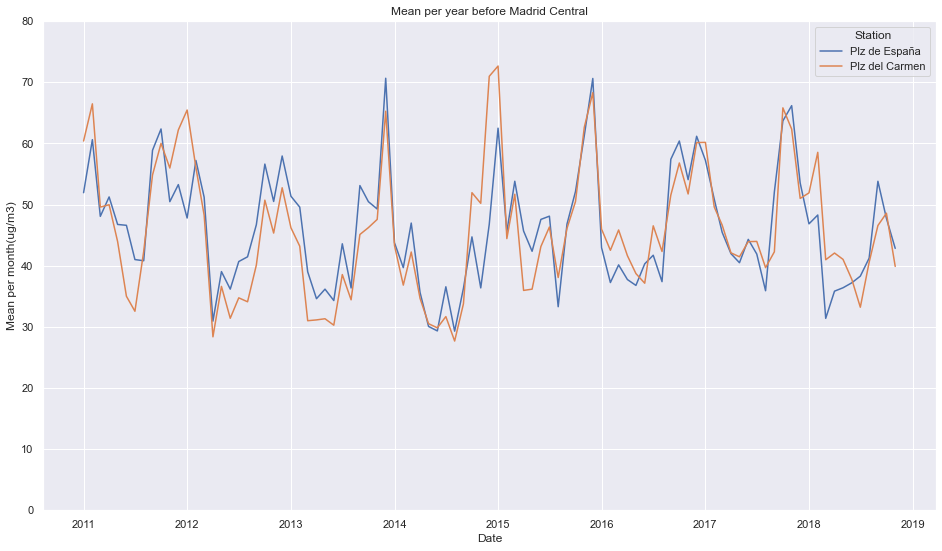

In [15]:
all_data_before = all_data[["Year", "Station", "Mean per month(ug/m3)"]].loc["2011-01-01":"2018-11-01"]

sns.set_theme(style='darkgrid')
plt.figure(figsize=(16,9))

g = sns.lineplot(data=all_data_before, x=all_data_before.index, y="Mean per month(ug/m3)", hue="Station")

g.set(title="Mean per year before Madrid Central")
g.set(ylim=(0, 80));

#### Year average
(for 2018, the month of December has not been taken into account as there was already Madrid Central)

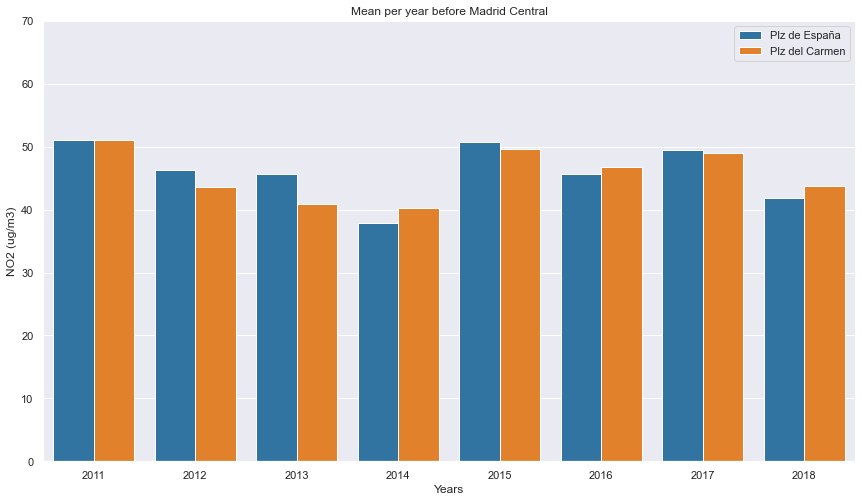

In [16]:
sns.set_style("darkgrid")
g = sns.catplot(
    data=all_data_before, kind="bar",
    x="Year", y="Mean per month(ug/m3)", hue="Station", capsize=.2, ci=None,  palette ="tab10", legend=False)

g.set_axis_labels("Years", "NO2 (ug/m3)")
g.set(title="Mean per year before Madrid Central")
g.set(ylim=(0, 70))
g.fig.set_figwidth(13)
g.fig.set_figheight(7)
plt.legend(loc="upper right");

In [17]:
all_data[["Year", "Station", "Mean per month(ug/m3)"]].loc["2011-01-01":"2018-11-01"].groupby(["Station", "Year"]).mean().round(2)

Mean per month(ug/m3)
Station        Year                       
Plz de España  2011                  51.00
               2012                  46.35
               2013                  45.70
               2014                  37.95
               2015                  50.80
               2016                  45.60
               2017                  49.46
               2018                  41.80
Plz del Carmen 2011                  51.10
               2012                  43.65
               2013                  40.85
               2014                  40.30
               2015                  49.66
               2016                  46.73
               2017                  49.08
               2018                  43.73

We notice that we have met the 40 ug / m3 limits only in 2014 in Plaza de España.

#### Plot of the monthly averages by season of the year

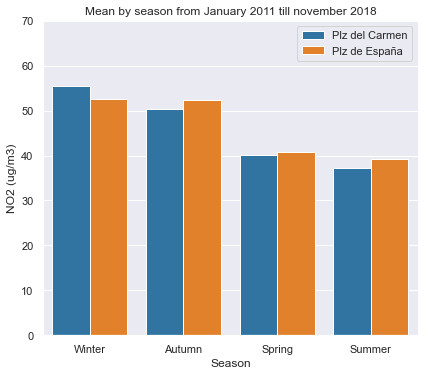

In [18]:
data_estacion = all_data[["Year", "Station","Season", "Mean per month(ug/m3)"]].loc["2011-01-01":"2018-11-01"].sort_values(by="Mean per month(ug/m3)",ascending=False)
g = sns.catplot(
    data=data_estacion, kind="bar",
    x="Season", y="Mean per month(ug/m3)", hue="Station", capsize=.2, ci=None,  palette ="tab10", legend=False)
g.set_axis_labels("Season", "NO2 (ug/m3)")
g.set(title="Mean by season from January 2011 till november 2018");
g.set(ylim=(0, 70))
g.fig.set_figwidth(6)
g.fig.set_figheight(5)
plt.legend(loc="upper right");

#### Given the great difference between one season to the other, let's have a look at the averages according to the month of the year:

In [19]:
all_data[["Month","Station","Mean per month(ug/m3)"]].loc["2011-01-01":"2018-11-01"].groupby(["Station","Month"]).mean().round(2)

Mean per month(ug/m3)
Station        Month                       
Plz de España  1                      50.54
               2                      48.63
               3                      44.50
               4                      39.20
               5                      38.50
               6                      39.47
               7                      41.48
               8                      36.96
               9                      50.63
               10                     54.76
               11                     51.37
               12                     59.13
Plz del Carmen 1                      55.75
               2                      49.70
               3                      44.53
               4                      38.24
               5                      37.47
               6                      36.06
               7                      38.44
               8                      37.39
               9                      45.03
               10                     53.82
               11                     51.95
               12                     61.51

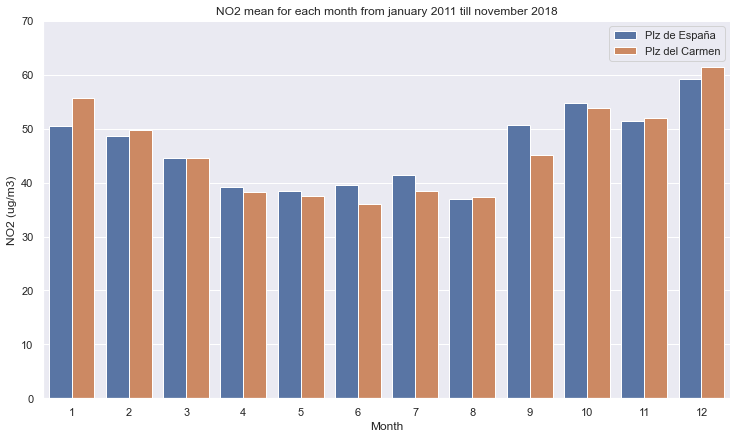

In [20]:
data_before = all_data[["Month", "Station", "Mean per month(ug/m3)"]].loc["2011-01-01":"2018-11-01"]

g = sns.catplot(
    data=data_before, kind="bar",
    x="Month", y="Mean per month(ug/m3)", hue="Station", capsize=.2, ci=None, legend=False)
g.set_axis_labels("Month", "NO2 (ug/m3)")
g.set(title="NO2 mean for each month from january 2011 till november 2018");
g.set(ylim=(0, 70))
g.fig.set_figwidth(11)
g.fig.set_figheight(6)
plt.legend(loc="upper right");

We can see that the most polluting months are January, February, March, September, October, November and December.

## NO2 POLLUTION AFTER THE IMPLEMENTATION OF MADRID CENTRAL

#### Graph of the monthly averages from December 2018 to February 2020 (we stopped before the corona virus lockdown).

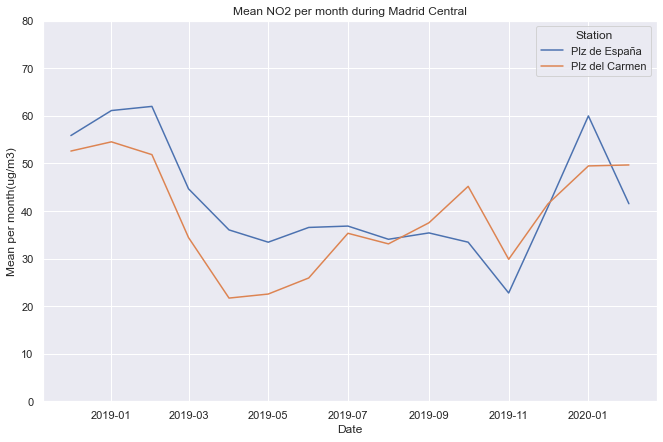

In [21]:
all_data_MadC = all_data[["Year", "Station", "Mean per month(ug/m3)"]].loc["2018-12-01":"2020-02-01"]

plt.figure(figsize=(11,7))

g = sns.lineplot(data=all_data_MadC, x=all_data_MadC.index, y="Mean per month(ug/m3)", hue="Station")

g.set(title="Mean NO2 per month during Madrid Central")
g.set(ylim=(0, 80));

#### let's have a closer look at the averages according to the month of the year

In [22]:
all_data[["Month","Station","Mean per month(ug/m3)"]].loc["2018-12-01":"2020-02-01"].groupby(["Station","Month"]).mean().round(2)

Mean per month(ug/m3)
Station        Month                       
Plz de España  1                      60.56
               2                      51.77
               3                      44.68
               4                      36.03
               5                      33.45
               6                      36.55
               7                      36.84
               8                      34.06
               9                      35.40
               10                     33.45
               11                     22.77
               12                     48.34
Plz del Carmen 1                      52.02
               2                      50.77
               3                      34.43
               4                      21.70
               5                      22.55
               6                      25.93
               7                      35.32
               8                      33.10
               9                      37.53
               10                     45.19
               11                     29.86
               12                     47.05

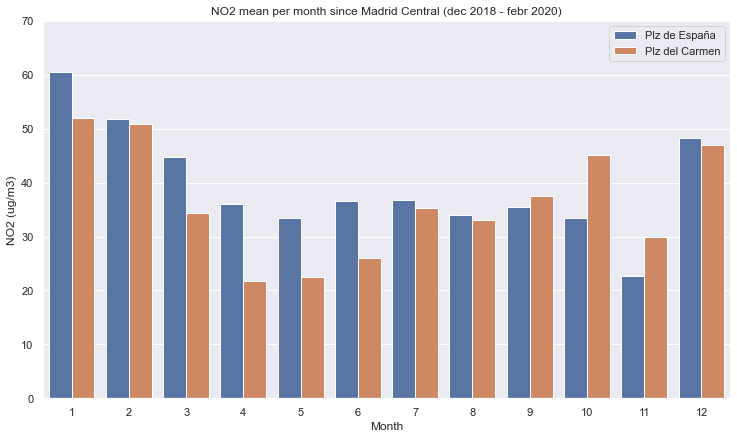

In [23]:
#We draw a bar graph with the monthly averages. A downward trend can be seen compared to the bar graph of the period prior to Madrid Central
data_after = all_data[["Month", "Station", "Mean per month(ug/m3)"]].loc["2018-12-01":"2020-02-01"]
g = sns.catplot(
    data=data_after, kind="bar",
    x="Month", y="Mean per month(ug/m3)", hue="Station", capsize=.2, ci=None, legend=False)
g.set_axis_labels("Month", "NO2 (ug/m3)")
g.set(title="NO2 mean per month since Madrid Central (dec 2018 - febr 2020)");
g.set(ylim=(0, 70))
g.fig.set_figwidth(11)
g.fig.set_figheight(6)
plt.legend(loc="upper right");

#### Comparison of the monthly averages of each month with the corresponding month of the previous year

In [24]:
# The "shift" is fixed at 24 because there are 2 stations per month and thus it will go one year back.
all_data["Previous year"] = 100 * (all_data["Mean per month(ug/m3)"] - all_data["Mean per month(ug/m3)"].shift(24)) / all_data["Mean per month(ug/m3)"].shift(24)

all_data_MadC = all_data[['Mean per month(ug/m3)','Station', 'Previous year']].loc["2018-12-01":"2020-02-01"]

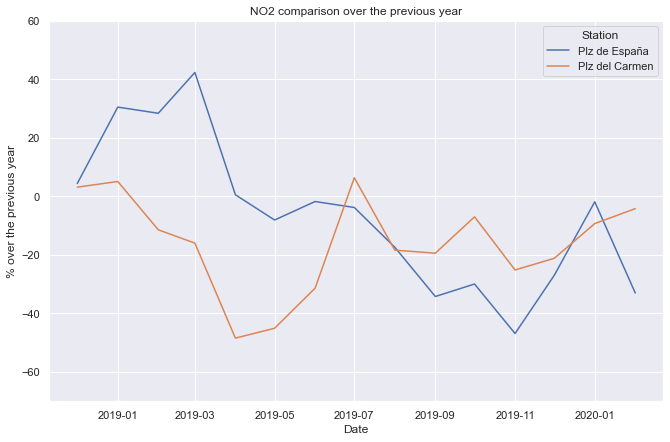

In [25]:
plt.figure(figsize=(11,7))

g = sns.lineplot(data=all_data_MadC, x=all_data_MadC.index, y="Previous year", hue="Station")

g.set(title="NO2 comparison over the previous year")
g.set(ylim=(-70, 60))
plt.ylabel('% over the previous year');

It can be seen that the curves are mostly below 0. Let's see it in more detail.
We are going to compare the first year of Madrid Central with the previous year:

In [26]:
# First year of Madrid Central
round(all_data[["Station","Previous year"]].loc["2018-12-01":"2019-11-01"].groupby("Station").mean())

,Previous year
Station,
Plz de España,-3.0
Plz del Carmen,-17.0


We create a function to compare a period with the same period of the previous year:

In [27]:
def month_to_previous_year(estacion, fecha1, fecha2):
    
    """
    This function compares the data of a period with the one of the previous year.
    
    We have 3 variables: the meteorological station, the starting date of the period and the ending date of the period
    
    """
    if estacion == "Plaza de España":
        
        return round(all_data[mask_espania]["Previous year"].loc[fecha1:fecha2].mean())
    
    if estacion == "Plaza del Carmen":
        return round(all_data[mask_carmen]["Previous year"].loc[fecha1:fecha2].mean())
    

We compare the averages during the transition period of Madrid Central (December 2018 - March 2019) with a year ago:

In [28]:
#For plaza españa:
month_to_previous_year("Plaza de España","2018-12-01","2019-03-01")

26

In [29]:
#For plaza del Carmen:
month_to_previous_year("Plaza del Carmen","2018-12-01","2019-03-01")

-5

and after the transition period until reaching the first year of Madrid Central

In [30]:
#For plaza españa:
month_to_previous_year("Plaza de España","2019-04-01","2019-11-01")

-18

In [31]:
#For plaza del Carmen:
month_to_previous_year("Plaza del Carmen","2019-04-01","2019-11-01")

-24

Let's have a look at the start of the second year of Madrid Central (therefore compared to the first months of the transition period)

In [32]:
#For plaza españa:
month_to_previous_year("Plaza de España","2019-12-01","2020-02-01")

-21

In [33]:
#For plaza del Carmen:
month_to_previous_year("Plaza del Carmen","2019-12-01","2020-02-01")

-12

Let's find out how the average NO2 of the year 2019:

In [34]:
all_data[["Year", "Station", "Mean per month(ug/m3)"]].loc["2019-01-01":"2019-12-01"].groupby("Station").mean().round(2)

,Year,Mean per month(ug/m3)
Station,,
Plz de España,2019,39.76
Plz del Carmen,2019,36.12


We can see that both means are below 40 ug / m3.

# CONCLUSION
The NO2 contamination data provided by the Madrid City indicates that, since the implementation of Madrid Central, the pollution have dropped significantly in both Plaza del Carmen and Plaza de España after the transition.

Both the monthly averages and the comparison of each month with the same month of the previous year corroborate this decrease.

### BONUS TRACK - What happened after the state of alarm (as of July 2020)??

We can notice that we are facing a N02 contamination with historical lows. That last graphic is for informational purposes only. Given the Corona virus crisis and its impact on our habits, we will not draw any conclusions regarding the influence of Madrid Central on these data.

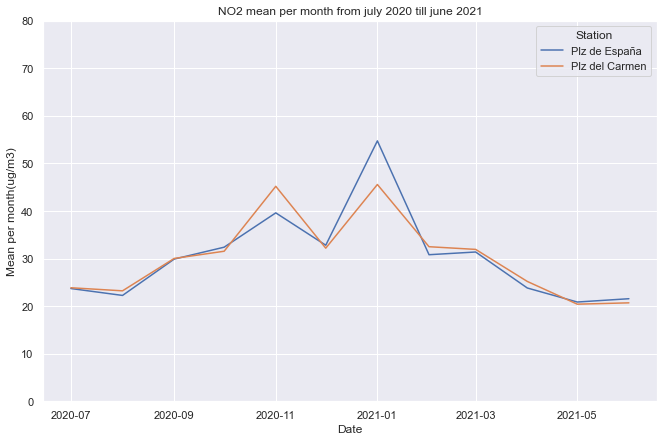

In [35]:
bonus_track = all_data[["Year", "Station", "Mean per month(ug/m3)"]].loc["2020-07-01":"2021-06-01"]

plt.figure(figsize=(11,7))

g = sns.lineplot(data=bonus_track, x=bonus_track.index, y="Mean per month(ug/m3)", hue="Station")

g.set(title="NO2 mean per month from july 2020 till june 2021")
g.set(ylim=(0, 80));